# Back testing model and generating pairs

First we import the key libraries and packages that we'll be using. Random seed is set to create replicable results.

In [1]:
import numpy as np
import pandas as pd

import statsmodels
from statsmodels.tsa.stattools import coint
# just set the seed for the random number generator
np.random.seed(107)
from statsmodels.tsa.stattools import adfuller

import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
%matplotlib inline
import math

from pandas_datareader import data
import datetime
import quandl

### find pairs that are cointegrated 

In [2]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


In [3]:
def find_meanReverting_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = adfuller(S1/S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs


### import data

In [4]:

from backtester.dataSource.yahoo_data_source import YahooStockDataSource
from datetime import datetime

startDateStr = '2017/10/02'
endDateStr = '2020/10/30'
cachedFolderName = 'yahooData/'
dataSetId = 'testPairsTrading'
instrumentIds = ['DIA','QQQ','MDT','BSX',
                 'FB','EBAY','GILD','NVO','SYK','GOOG','AAPL','AMZN','NFLX','TWTR','SNAP','ADBE',
                 'VGT','WBC','CVS','ALXN','CNC'] 
#['ANN.ax','COH.ax','CSL.ax','EHE.ax','HLS.ax','NAN.ax','PME.ax','SHL.ax'] 
ds = YahooStockDataSource(cachedFolderName=cachedFolderName,
                            dataSetId=dataSetId,
                            instrumentIds=instrumentIds,
                            startDateStr=startDateStr,
                            endDateStr=endDateStr,
                            event='history')
data = ds.getBookDataByFeature()['adjClose']

Processing data for stock: DIA
Processing data for stock: QQQ
Processing data for stock: MDT
Processing data for stock: BSX
Processing data for stock: FB
Processing data for stock: EBAY
Processing data for stock: GILD
Processing data for stock: NVO
Processing data for stock: SYK
Processing data for stock: GOOG
Processing data for stock: AAPL
Processing data for stock: AMZN
Processing data for stock: NFLX
Processing data for stock: TWTR
Processing data for stock: SNAP
Processing data for stock: ADBE
Processing data for stock: VGT
Processing data for stock: WBC
Processing data for stock: CVS
Processing data for stock: ALXN
Processing data for stock: CNC
20% done...
40% done...
60% done...
80% done...


In [5]:
data.head()

,DIA,QQQ,MDT,BSX,FB,EBAY,GILD,NVO,SYK,GOOG,...,AMZN,NFLX,TWTR,SNAP,ADBE,VGT,WBC,CVS,ALXN,CNC
2017-10-02,215.571823,143.191284,74.695877,29.469999,169.470001,38.303307,78.151741,46.633610,140.323349,953.270020,...,959.190002,177.009995,17.09,14.88,147.940002,148.786819,148.059998,75.427628,140.919998,48.480000
2017-10-03,216.528900,143.496170,74.753304,29.020000,169.960007,38.283527,77.842949,46.776634,140.440689,957.789978,...,957.099976,179.190002,17.59,14.64,148.600006,149.167511,149.410004,75.558380,141.479996,48.485001
2017-10-04,216.691650,143.633896,75.250946,29.240000,168.419998,38.234077,77.122437,46.986389,142.728745,951.679993,...,965.450012,184.449997,17.75,14.53,147.949997,149.079681,151.470001,74.773933,141.929993,48.384998
2017-10-05,217.868835,145.040436,76.093140,29.430000,171.240005,38.560444,78.142380,46.662212,145.016785,969.960022,...,980.849976,194.389999,18.25,14.48,150.250000,150.485336,150.210007,75.549049,143.789993,48.674999
2017-10-06,217.782745,145.237152,76.380241,29.500000,172.229996,38.382431,76.860435,46.833836,145.691452,978.890015,...,989.580017,198.020004,17.85,14.79,151.119995,150.944138,149.789993,71.832283,141.300003,49.005001


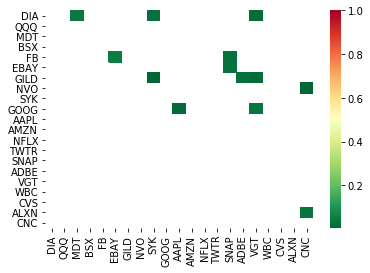

Co-integrated pairs found:   
 [('DIA', 'MDT'), ('DIA', 'SYK'), ('DIA', 'VGT'), ('FB', 'EBAY'), ('FB', 'SNAP'), ('EBAY', 'SNAP'), ('GILD', 'SYK'), ('GILD', 'ADBE'), ('GILD', 'VGT'), ('NVO', 'CNC'), ('GOOG', 'AAPL'), ('GOOG', 'VGT'), ('ALXN', 'CNC')]


In [6]:
# Heatmap to show the p-values of the cointegration test
# between each pair of stocks

scores, pvalues, pairs = find_cointegrated_pairs(data)
import seaborn
#m = [0,0.2,0.4,0.6,0.8,1]
m = np.linspace(0,1,6)
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
plt.show()
print("Co-integrated pairs found:   \n", pairs)

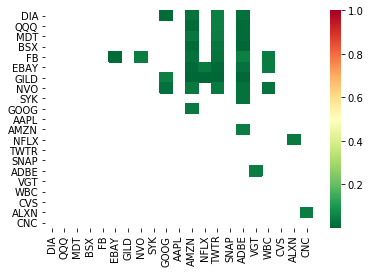

Mean Reverting pairs with no Unit-Root found:   
 [('DIA', 'GOOG'), ('DIA', 'AMZN'), ('DIA', 'TWTR'), ('DIA', 'ADBE'), ('QQQ', 'AMZN'), ('QQQ', 'TWTR'), ('QQQ', 'ADBE'), ('MDT', 'AMZN'), ('MDT', 'TWTR'), ('MDT', 'ADBE'), ('BSX', 'AMZN'), ('BSX', 'TWTR'), ('BSX', 'ADBE'), ('FB', 'EBAY'), ('FB', 'NVO'), ('FB', 'AMZN'), ('FB', 'TWTR'), ('FB', 'ADBE'), ('FB', 'WBC'), ('EBAY', 'AMZN'), ('EBAY', 'NFLX'), ('EBAY', 'TWTR'), ('EBAY', 'ADBE'), ('EBAY', 'WBC'), ('GILD', 'GOOG'), ('GILD', 'AMZN'), ('GILD', 'NFLX'), ('GILD', 'TWTR'), ('GILD', 'ADBE'), ('NVO', 'GOOG'), ('NVO', 'AMZN'), ('NVO', 'TWTR'), ('NVO', 'ADBE'), ('NVO', 'WBC'), ('SYK', 'ADBE'), ('GOOG', 'AMZN'), ('AMZN', 'ADBE'), ('NFLX', 'ALXN'), ('ADBE', 'VGT'), ('ALXN', 'CNC')]


In [7]:
# Heatmap to show the p-values of the ADF test
# between each pair of stocks

scores, pvalues, pairs = find_meanReverting_pairs(data)
import seaborn
#m = [0,0.2,0.4,0.6,0.8,1]
m = np.linspace(0,1,6)
seaborn.heatmap(pvalues, xticklabels=instrumentIds, 
                yticklabels=instrumentIds, cmap='RdYlGn_r' 
                , mask = (pvalues >= 0.05)
                )
plt.show()
print("Mean Reverting pairs with no Unit-Root found:   \n", pairs)

### Choose a pair and test

P-Value                        :  0.04901
T-stat score for co-integration:  -3.34363


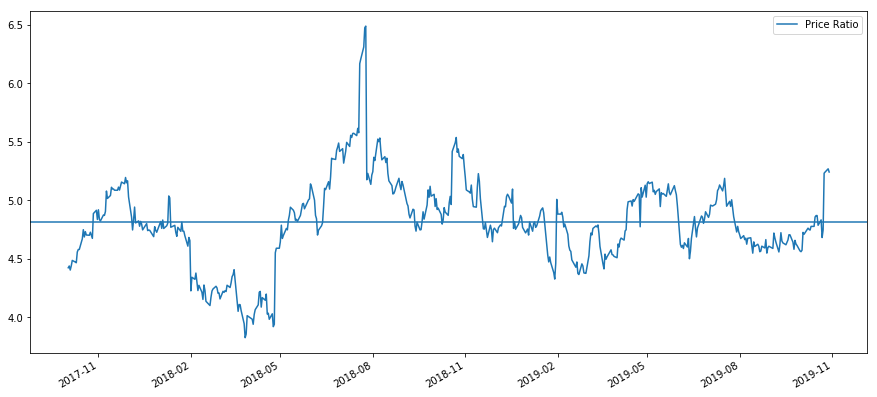

In [8]:
S1 = data['FB']
S2 = data['EBAY']
ticker_1 = "FB"
ticker_2 = "EBAY"
score, pvalue, _ = coint(S1, S2)
print('P-Value                        : ',pvalue.round(5))
print("T-stat score for co-integration: ",score.round(5))
ratios = S1 / S2
ratios.plot(figsize=(15,7))
plt.axhline(ratios.mean())
plt.legend(['Price Ratio'])
plt.show()

### Co-Integration, Augmented Dickey Fuller, Correlation and Covariance test

In [9]:
t_stat_summary = statsmodels.tsa.stattools.coint(S1, S2, trend='c', method='aeg', maxlag=None, autolag='aic', return_results=True) 

In [10]:
print('----------Co-Integration Test-------------------')
print('T-stat for the pair {} VS {}:'.format(ticker_1,ticker_2), t_stat_summary[0])
print('Alpha value for the T-stat:  {}'.format(t_stat_summary[1]))
print('--------------------------------------')
print('T-stat 99%:  {}'.format(t_stat_summary[2][0]))
print('T-stat 95%:  {}'.format(t_stat_summary[2][1]))
print('T-stat 90%:  {}'.format(t_stat_summary[2][2]))

----------Co-Integration Test-------------------
T-stat for the pair FB VS EBAY: -3.343627583783021
Alpha value for the T-stat:  0.04900886055009106
--------------------------------------
T-stat 99%:  -3.917543693427871
T-stat 95%:  -3.347860212416142
T-stat 90%:  -3.0525848864520486


In [11]:
# ADF check
from statsmodels.tsa.stattools import adfuller
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('---------Augmented Dickey-Fuller Test--------')
    
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
adf_check(ratios)

---------Augmented Dickey-Fuller Test--------
ADF Test Statistic : -3.4927787961405583
p-value : 0.008174498201274034
#Lags Used : 0
Number of Observations Used : 522
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [12]:
corr_M = np.corrcoef(S1,S2)
print("Correlation Matrix:  ")
print("__________________")
print(corr_M)

Correlation Matrix:  
__________________
[[1.        0.7071513]
 [0.7071513 1.       ]]


### Normalise the Data and Plot the ratios, and Z-values

In [13]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

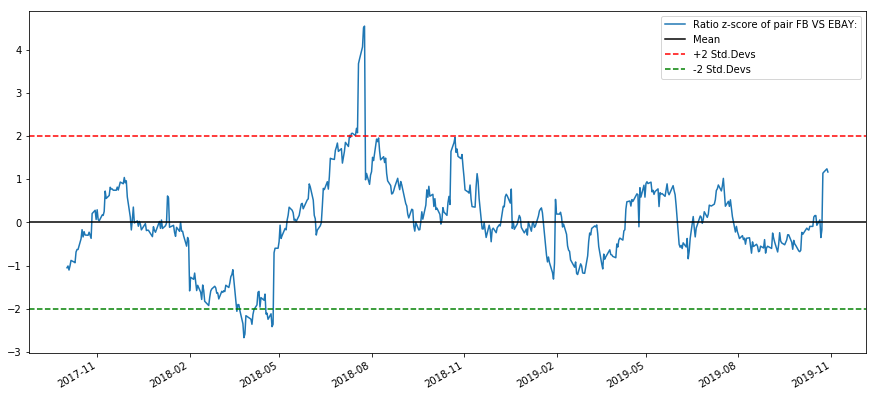

In [14]:
zscore(ratios).plot(figsize=(15,7))
plt.axhline(zscore(ratios).mean(), color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Ratio z-score of pair {} VS {}:'.format(ticker_1,ticker_2), 'Mean', '+2 Std.Devs', '-2 Std.Devs'])
plt.show()

In [15]:
ratios = S1 / S2
print(len(ratios))
train = ratios[:404]
test = ratios[404:]

523


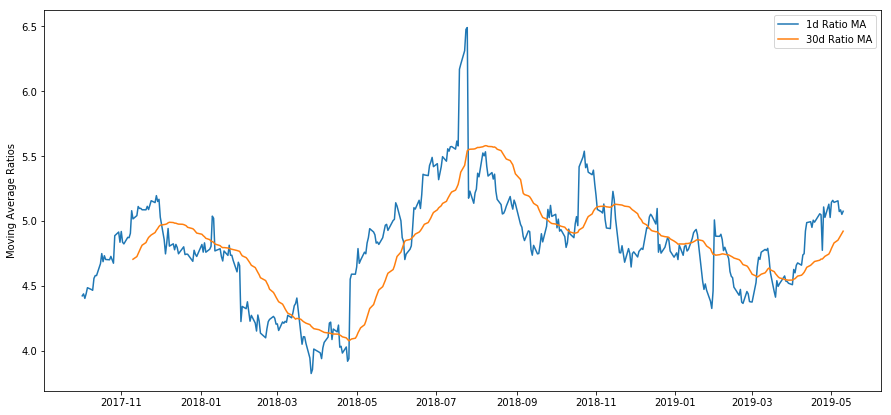

In [16]:
ratios_mavg1 = train.rolling(window=1,
                               center=False).mean()

ratios_mavg_long = train.rolling(window=30,
                               center=False).mean()

std_long = train.rolling(window=30,
                        center=False).std()

zscore_long_1 = (ratios_mavg1 - ratios_mavg_long)/std_long
plt.figure(figsize=(15,7))
plt.plot(ratios_mavg1.index, ratios_mavg1.values)
plt.plot(ratios_mavg_long.index, ratios_mavg_long.values)

plt.legend(['1d Ratio MA', '30d Ratio MA'])

plt.ylabel('Moving Average Ratios')
plt.show()

We create a z score for the the difference between the original ratio values and the 30 day moving average. We plot the upper and lower thresholds at +2 standard deviations and - 2 standard deviations. 
These thresholds help us to create our buy and sell signals. 

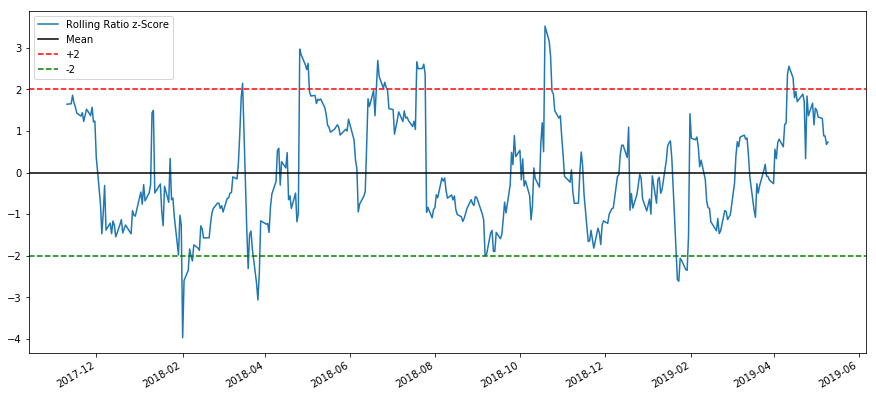

In [17]:
# Take a rolling 30 day standard deviation
std_long = train.rolling(window=30,center=False).std()
std_long.name = 'std 30d'

# Compute the z score for each day
zscore_long_1 = (ratios_mavg1 - ratios_mavg_long)/std_long
zscore_long_1.name = 'z-score'

plt.figure(figsize=(15,7))
zscore_long_1.plot()
plt.axhline(0, color='black')
plt.axhline(2.0, color='red', linestyle='--')
plt.axhline(-2.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+2', '-2'])
plt.show()


## Plotting Buy and Sell signals

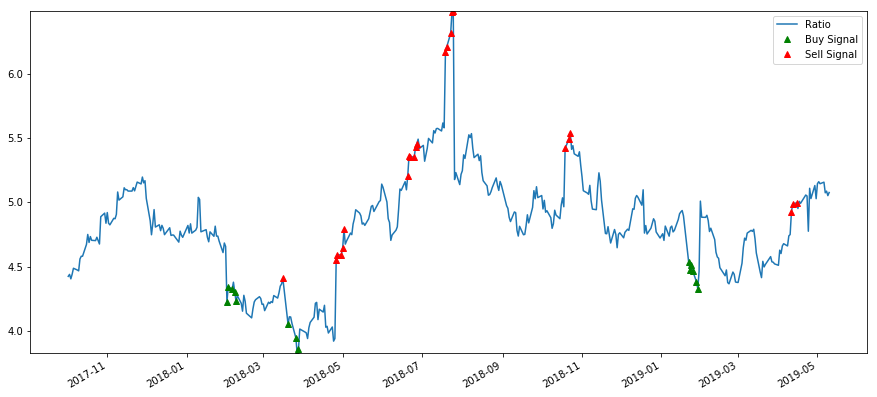

In [18]:
# Plot the ratios and buy and sell signals from z score
plt.figure(figsize=(15,7))

train[0:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_long_1>-2] = 0
sell[zscore_long_1<2] = 0
buy[60:].plot(color='g', linestyle='None', marker='^')
sell[60:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,ratios.min(),ratios.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

Next we plot the original prices of the two stocks along with the corresponding buy and sell signals.


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match

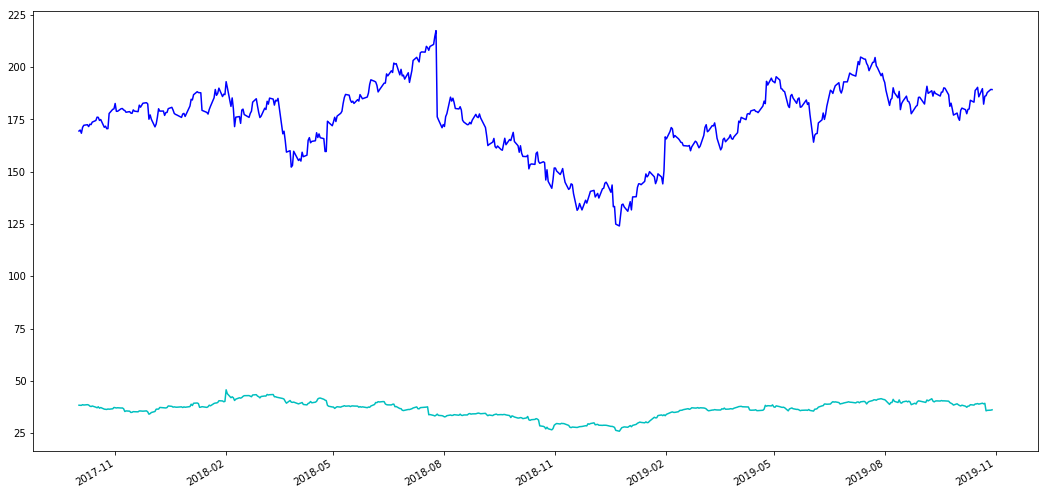

In [19]:
# Plot the prices and buy and sell signals from z score
plt.figure(figsize=(18,9))


S1[0:].plot(color='b')
S2[0:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When buying the ratio, buy S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]
# When selling the ratio, sell S1 and buy S2 
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[0:].plot(color='g', linestyle='None', marker='^')
sellR[0:].plot(color='r', linestyle='None', marker='^')
x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,min(S1.min(),S2.min()),max(S1.max(),S2.max())))

plt.legend(['Stock1','Stock2', 'Buy Signal', 'Sell Signal'])
plt.show()

## Bakctesting the Strategy for the Pair

In [ ]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 100000
    countS1 = 0
    countS2 = 0
    money_counter = []
    for i in range(len(ratios)):
        # adjust lot size based on current balance
        #lot_size = round(money*0.005/S1[i])
        lot_size = 100
        # Sell short if the z-score is > 2
        if zscore[i] > 2.0:
            money += S1[i]*lot_size - S2[i] * ratios[i]*lot_size
            money_counter.append(money)
            countS1 -= 1
            countS2 += ratios[i]
            print('Selling Ratio %s %s %s %s'%(round(money,2), round(ratios[i],2), round(countS1,2),round(countS2,2)))
            
        # Buy long if the z-score is < -2
        elif zscore[i] < -2.0:
            money -= S1[i]*lot_size - S2[i] * ratios[i]*lot_size
            money_counter.append(money)
            countS1 += 1
            countS2 -= ratios[i]
            print('Buying Ratio %s %s %s %s'%(round(money,2), round(ratios[i],2), round(countS1,2),round(countS2,2)))
        # Clear positions if the z-score between -.1 and .1
        elif abs(zscore[i]) < 0.1:
            money += countS1*S1[i]*lot_size - S2[i] * countS2*lot_size
            money_counter.append(money)
            countS1 = 0
            countS2 = 0
            print('Exit pos %s %s %s %s'%(round(money,2), round(ratios[i],2), round(countS1,2),round(countS2,2)))
    return money_counter

balance = trade(S1.iloc[0:], S2.iloc[0:], 1, 30)
td = (balance[-1])
print("backtested ratio: ", ratios[-1:])
print("Profit from the pair:  ", round(td,2))
#td_100 = td * 100
#print("Profit from 100 units at above ratio:  ", td_100)

## Model Statistics

In [ ]:
print("Final Account Balance:  ", round(td,2))
total_profit = td - 100000
print("Total Profit Made:      ", round(total_profit,2))
absolute_Dollar_ROI = total_profit/100000
print("Absolute ROI:            {:.02%}".format(absolute_Dollar_ROI))

In [ ]:
balance_df = pd.DataFrame(balance)

In [ ]:
ret_df = balance_df.drop_duplicates().diff()
ret_df_unique = ret_df.dropna()
print(round(ret_df_unique),0)

In [ ]:
Sharpe_ratio = ret_df_unique.mean()/ret_df_unique.std() * np.sqrt(252)
print("Sharpe Ratio for the pair NAB/WBC:   ", round(Sharpe_ratio[0],3))

In [ ]:
n_years = (datetime.strptime(endDateStr, '%Y/%m/%d') - datetime.strptime(startDateStr, '%Y/%m/%d')).days/365
cagr = (balance[-1]/balance[0])**(1/n_years)-1
print("Compunded Annual Growth Rate:  {:.0%}".format(cagr))

In [ ]:
from matplotlib.ticker import FuncFormatter
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day 
rolling_max = balance_df.rolling(window, min_periods=1).max()
daily_drawdown = (balance_df/rolling_max - 1.0)

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
ax_1 = daily_drawdown.plot()
plt.legend(['Drawdown'])
ax_2 = max_daily_drawdown.plot()
plt.legend(['Drawdown'])
ax_1.yaxis.set_major_formatter(FuncFormatter('{:.02%}'.format)) 
ax_2.yaxis.set_major_formatter(FuncFormatter('{:.02%}'.format)) 

# Show the plot
plt.show()


### Summary 

In [ ]:
print("Summary of Stats for the model")
print("______________________________")
print("Final Account Balance:              ", round(td,2))
print("Total Profit Made:                  ", round(total_profit,2))
print("Absolute ROI:                        {:.02%}".format(absolute_Dollar_ROI))
print("Sharpe Ratio for the pair NAB/WBC:  ", round(Sharpe_ratio[0],3))
print("Compunded Annual Growth Rate:        {:.0%}".format(cagr))

This strategy looks at the mean reversion property of the 2 chosen stocks which are tested for co-integration and non-stationarity. This pair trading ratio model is one of the market neutral trading strategies which would work in virtually any market conditions. Selecting the pair is, of course, the critical factor in the strategy. Even though it has been tested for a high correlation between the chosen pair, extreme economic conditions have effects on the relationship of the pair. The model in general assumes a normal distribution from the ratio when the true distribution of the ratios could be fat-tailed. As a result, the selected threshold rule for the model may no longer be profitable, even if the correlation still holds. A better selection criterion could certainly help. Something like the Kalman Filter provides superior estimates of the hedge ratio (Kinlay, 2018).
The back-testing result has identified 93 in a 456 day period. This brings in another factor, known as the implementation risk. Identifying a signal is one thing while executing is another. This strategy imposes high commission costs due to the high frequency of buying and selling. A better model should also price in the slippage and commissions, as well as consider for a bid-ask spread for the buy or sell orders. 
In the model, a window period of 30 days was selected but it is reasonable to optimize the window length simply by iterating all possible, reasonable window length and pick the length based on which the model performs the best. Alternatively, the window length could also be dynamic by using the Kalman filters. The Kalman Filter approach has been successfully applied in developing statistical arbitrage strategies, especially for processes where the noise ratio is not too large (Kinlay, 2018). 
Rather than selecting a constant pair to trade, it may be possible to include all other co-integrated Australia banking stocks into the price ratios. This is to ensure the selection of the pair with the highest divergence in price.    
To improve the reliability of the trading signals, it is proposed to adopt Google Trend searches and Twitter sentiment analysis into the algorithm.
Forecasting stock market movements using Google Trend Searches

If searches for a Google term of the trading company have increased at the end of a three-day period, then it is expected an upturn in the market, then go for a long position. If searches for a Google term of the trading company have decreased at the end of a three-day period, then it is an expected downturn in the market, then go for a short position.Analyzing stock market movements using Twitter Sentiment Analysis

In this age of fast-paced information dissemination, short term sentiments play a very important role in the short term performance of financial market instruments such as indexes and stocks. It is well accepted that news drives macro-economic movement in the markets, while researches suggest that social media buzz is highly influential at the micro-economic level, especially in the financial markets. The negative and positive dimensions of public mood carry a strong cause-effect relationship with price movements of individual stocks/indices. Base on the research that individual company stocks gave strong correlation values with twitter sentiment features of that company, we can adopt the Twitter Sentiment Analysis into the buy/sell decision making process.


####Use of GARCH instead of regular variance to account for heteroscedasticity would improve the returns of the model.
(Pairs Trading via Three-Regime Threshold Autoregressive GARCH Models, Cathy W.S. Chen_, Max Chen, and Shu-Yu Chen)

####Transaction costs which could have a significant impact on the profitability of any model has not been factored into the above model. Hence this is a significant limiting factor of this model that should be accounted for.

####It is not clear of the level of quality in our dataset. OHLC data was used in this model from yahoo finance for free. A clean professional level dataset would eliminate any data errors in the model.
####Backtest performance can often differ from live performance as orders are routed to different exchanges – eg. ASX to Chi-X in Australia. The prices can also become simply tick errors that should be excluded if they are made with extremely low volumes that makes it unrealistic to expect an order fill at those prices.

####Type of orders used to fill the entry and exits will also affect the profitability of the strategy. Limit orders only will ensure the exact price desired is filled vs market orders will ensure instant fulfilment at an average available price. Backtests based on either method will show different results. When backtesting, it is essential to model the effects of using market or limit orders correctly. For high-frequency strategies in particular, backtests can significantly outperform live trading if the effects of market impact and the limit order book is not modelled accurately.

####Market impact/Liquidity needs to be accounted for as smaller volume-based stock would be highly inappropriate to use for pair trades. When executing trades on low volume stocks, this can affect the price of the stock in the market causing detrimental effects on profitability. In addition, a low liquidity stock would make it difficult to exit a pair trade at speed. Hence high frequency-based trades on pairs would require higher liquidity factors to be considered.

Latency of the execution platform will have a significant impact on high frequency pair trades. Hence it is also important to ensure a low-latent platform is used for higher frequency models. 

####On our model we do not use the dynamic position sizing based on account value. We use a static 1000 units of Stock-1 as an arbitrary size. This can be improved by making the position sizes reflect the account value as a percentage of the account value.

Finally, we should also consider implementing a “time” stop to the trades. By exiting the trade at a certain time interval would minimize losses incurred in cases where the model simply doesn’t move between the two standard deviations or the co-integration relationship ceases to exist etc.

